# Epoch 8
[Slides](https://docs.google.com/presentation/d/1KvTFFgl95u5qHDb1ek9ELNVqcvkza5OiSUGWGOEWMX4/edit?usp=sharing)

In [0]:
import os
import keras
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist,fashion_mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [0]:
!mkdir /content/models
!mkdir /content/images

In [0]:
# If you don't want to see the same results every time, remove the line below.
np.random.seed(512)

input_dim = 100

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

Instructions for updating:
Colocations handled automatically by placer.


# **Fashion-MNIST**

Fashion-MNIST is a dataset of Zalando's article images consisting of a set of 60,000 examplex and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others."

**Labels**

*   0 T_shirt/top
*   1 Trousers
*   2 Pullover
*   3 Dress
*   4 Coat
*   5 Sandal
*   6 Shirt
*   7 Sneaker
*   8 Bag
*   9 Ankle boot 








![alt text](https://markusthill.github.io/images/2017-10-12-zalandos-fashion-mnist-dataset/zalando10x10.jpeg)

In [0]:
# Load fashion MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

4423680/4422102 [==============================] - 0s 0us/step


# **Generator**

---
The Generator takes random noise as an input and generates samples as an output. It’s goal is to generate such samples that will fool the Discriminator to think that it is seeing real images while actually seeing fakes. We can use this information to feed the Generator and perform backpropagation.

![alt text](https://www.researchgate.net/profile/Sinan_Kaplan2/publication/319093376/figure/fig19/AS:526859936571392@1502624605005/Architecture-of-proposed-generator-network-which-is-part-of-GAN-based-on-CNN-units-with.png)

In [0]:
# Generator
generator = Sequential()
generator.add(Dense(256, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

# **Discriminator**

---
Discriminator takes both real images from the input dataset and fake images from the Generator and outputs a verdict whether a given image is legit or not. We can think of the Discriminator as a policeman trying to catch the bad guys while letting the good guys free.

![alt text](https://cdn-images-1.medium.com/max/1600/1*QWEQqXmdTF285r1uS1t2eg.png)

In [0]:
# Discriminator
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


GANs are designed to create a [Nash equilibrium](https://en.wikipedia.org/wiki/Nash_equilibrium) at which each player cannot reduce their cost without changing the other player's parameters.

GAN data flow can be represented as in the following diagram.

![alt text](https://cdn-images-1.medium.com/max/1600/1*XKanAdkjQbg1eDDMF2-4ow.png)



The math behind:

![alt text](https://cdn-images-1.medium.com/max/800/1*M_YipQF_oC6owsU1VVrfhg.jpeg)

In [0]:

# Combined network
discriminator.trainable = False
ganInput = Input(shape=(input_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []


In [0]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/images/gan_loss_epoch_%d.png' % epoch)

In [0]:
# Show generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, input_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/images/gan_generated_image_epoch_%d.png' % epoch)


In [0]:
# Save the model
def saveModels(epoch):
    generator.save('/content/models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('/content/models/gan_discriminator_epoch_%d.h5' % epoch)

In [0]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('\n','-'*20, 'Epoch %d' % e, '-'*20)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, input_dim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, input_dim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 10 == 0:
            plotGeneratedImages(e)
            saveModels(e)
    # Plot losses from every epoch
    plotLoss(e)


GANS are hard to train

Without the right hyperparameters, network architecture, and training procedure, there is a high chance that either the generator or discriminator will overpower the other.

A common case of this is the situation where the generator is able to find a flaw in the discriminator by repeatedly outputting an image that fits the data distribution the discriminator is looking for, but is nowhere close to being a readable MNIST digit. The generator has collapsed onto a single point, and therefore we won’t output a variety of digits.

There are also cases where the discriminator becomes too powerful and is able to easily make the distinction between real and fake images.

The mathematical intuition behind this phenomenon lies in that GANs are typically trained using gradient descent techniques that are designed to find the minimum value of a cost function, rather than to find the Nash equilibrium of a game. When used to seek for a [Nash equilibrium](https://en.wikipedia.org/wiki/Nash_equilibrium), these algorithms may fail to converge. 

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 100
Batch size: 128
Batches per epoch: 468.75

 -------------------- Epoch 1 --------------------
Instructions for updating:
Use tf.cast instead.


  1%|▏         | 7/468 [00:00<00:07, 63.74it/s]


 -------------------- Epoch 2 --------------------


  2%|▏         | 8/468 [00:00<00:05, 76.93it/s]


 -------------------- Epoch 3 --------------------


  2%|▏         | 8/468 [00:00<00:06, 71.19it/s]


 -------------------- Epoch 4 --------------------


  2%|▏         | 8/468 [00:00<00:06, 76.46it/s]


 -------------------- Epoch 5 --------------------


  2%|▏         | 8/468 [00:00<00:06, 73.94it/s]


 -------------------- Epoch 6 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.76it/s]


 -------------------- Epoch 7 --------------------


  1%|▏         | 7/468 [00:00<00:06, 69.87it/s]


 -------------------- Epoch 8 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.12it/s]


 -------------------- Epoch 9 --------------------


  2%|▏         | 8/468 [00:00<00:06, 76.14it/s]


 -------------------- Epoch 10 --------------------


  1%|▏         | 7/468 [00:00<00:07, 64.29it/s]


 -------------------- Epoch 11 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.23it/s]


 -------------------- Epoch 12 --------------------


  2%|▏         | 8/468 [00:00<00:06, 73.07it/s]


 -------------------- Epoch 13 --------------------


  2%|▏         | 8/468 [00:00<00:06, 72.76it/s]


 -------------------- Epoch 14 --------------------


  1%|▏         | 7/468 [00:00<00:06, 69.96it/s]


 -------------------- Epoch 15 --------------------


  1%|▏         | 7/468 [00:00<00:07, 63.56it/s]


 -------------------- Epoch 16 --------------------


  2%|▏         | 8/468 [00:00<00:06, 76.58it/s]


 -------------------- Epoch 17 --------------------


  2%|▏         | 8/468 [00:00<00:06, 73.55it/s]


 -------------------- Epoch 18 --------------------


  2%|▏         | 8/468 [00:00<00:05, 77.11it/s]


 -------------------- Epoch 19 --------------------


  2%|▏         | 8/468 [00:00<00:06, 71.35it/s]


 -------------------- Epoch 20 --------------------


  1%|▏         | 7/468 [00:00<00:07, 64.48it/s]


 -------------------- Epoch 21 --------------------


  1%|▏         | 7/468 [00:00<00:07, 63.69it/s]


 -------------------- Epoch 22 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.39it/s]


 -------------------- Epoch 23 --------------------


  1%|▏         | 7/468 [00:00<00:06, 68.22it/s]


 -------------------- Epoch 24 --------------------


  2%|▏         | 8/468 [00:00<00:06, 76.58it/s]


 -------------------- Epoch 25 --------------------


  1%|▏         | 7/468 [00:00<00:06, 68.39it/s]


 -------------------- Epoch 26 --------------------


  2%|▏         | 8/468 [00:00<00:06, 76.34it/s]


 -------------------- Epoch 27 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.90it/s]


 -------------------- Epoch 28 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.91it/s]


 -------------------- Epoch 29 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.62it/s]


 -------------------- Epoch 30 --------------------


  1%|▏         | 6/468 [00:00<00:08, 56.95it/s]


 -------------------- Epoch 31 --------------------


  1%|▏         | 7/468 [00:00<00:06, 66.97it/s]


 -------------------- Epoch 32 --------------------


  2%|▏         | 8/468 [00:00<00:06, 74.43it/s]


 -------------------- Epoch 33 --------------------


  2%|▏         | 8/468 [00:00<00:06, 74.42it/s]


 -------------------- Epoch 34 --------------------


  2%|▏         | 8/468 [00:00<00:06, 71.44it/s]


 -------------------- Epoch 35 --------------------


  2%|▏         | 8/468 [00:00<00:06, 72.43it/s]


 -------------------- Epoch 36 --------------------


  2%|▏         | 8/468 [00:00<00:05, 77.32it/s]


 -------------------- Epoch 37 --------------------


  2%|▏         | 8/468 [00:00<00:05, 77.76it/s]


 -------------------- Epoch 38 --------------------


  2%|▏         | 8/468 [00:00<00:05, 77.27it/s]


 -------------------- Epoch 39 --------------------


  2%|▏         | 8/468 [00:00<00:06, 76.21it/s]


 -------------------- Epoch 40 --------------------


  1%|▏         | 7/468 [00:00<00:06, 66.30it/s]


 -------------------- Epoch 41 --------------------


  2%|▏         | 8/468 [00:00<00:06, 72.32it/s]


 -------------------- Epoch 42 --------------------


  1%|▏         | 7/468 [00:00<00:06, 69.92it/s]


 -------------------- Epoch 43 --------------------


  2%|▏         | 8/468 [00:00<00:06, 71.38it/s]


 -------------------- Epoch 44 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.26it/s]


 -------------------- Epoch 45 --------------------


  2%|▏         | 8/468 [00:00<00:06, 71.76it/s]


 -------------------- Epoch 46 --------------------


  2%|▏         | 8/468 [00:00<00:06, 74.75it/s]


 -------------------- Epoch 47 --------------------


  2%|▏         | 8/468 [00:00<00:06, 74.17it/s]


 -------------------- Epoch 48 --------------------


  2%|▏         | 8/468 [00:00<00:06, 76.14it/s]


 -------------------- Epoch 49 --------------------


  2%|▏         | 8/468 [00:00<00:05, 78.64it/s]


 -------------------- Epoch 50 --------------------


  1%|▏         | 7/468 [00:00<00:07, 61.92it/s]


 -------------------- Epoch 51 --------------------


  2%|▏         | 8/468 [00:00<00:06, 71.35it/s]


 -------------------- Epoch 52 --------------------


  2%|▏         | 8/468 [00:00<00:05, 78.63it/s]


 -------------------- Epoch 53 --------------------


  2%|▏         | 8/468 [00:00<00:06, 73.25it/s]


 -------------------- Epoch 54 --------------------


  2%|▏         | 8/468 [00:00<00:06, 74.49it/s]


 -------------------- Epoch 55 --------------------


  1%|▏         | 7/468 [00:00<00:06, 69.68it/s]


 -------------------- Epoch 56 --------------------


  2%|▏         | 8/468 [00:00<00:06, 71.70it/s]


 -------------------- Epoch 57 --------------------


  2%|▏         | 8/468 [00:00<00:05, 79.32it/s]


 -------------------- Epoch 58 --------------------


  2%|▏         | 8/468 [00:00<00:05, 77.99it/s]


 -------------------- Epoch 59 --------------------


  2%|▏         | 8/468 [00:00<00:05, 77.17it/s]


 -------------------- Epoch 60 --------------------


  1%|▏         | 6/468 [00:00<00:08, 57.65it/s]


 -------------------- Epoch 61 --------------------


  1%|▏         | 6/468 [00:00<00:08, 56.67it/s]


 -------------------- Epoch 62 --------------------


  2%|▏         | 8/468 [00:00<00:06, 74.96it/s]


 -------------------- Epoch 63 --------------------


  2%|▏         | 8/468 [00:00<00:06, 76.04it/s]


 -------------------- Epoch 64 --------------------


  2%|▏         | 8/468 [00:00<00:05, 79.65it/s]


 -------------------- Epoch 65 --------------------


  2%|▏         | 8/468 [00:00<00:06, 73.53it/s]


 -------------------- Epoch 66 --------------------


  2%|▏         | 8/468 [00:00<00:06, 72.95it/s]


 -------------------- Epoch 67 --------------------


  2%|▏         | 8/468 [00:00<00:06, 71.68it/s]


 -------------------- Epoch 68 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.74it/s]


 -------------------- Epoch 69 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.84it/s]


 -------------------- Epoch 70 --------------------


  1%|▏         | 7/468 [00:00<00:07, 65.28it/s]


 -------------------- Epoch 71 --------------------


  2%|▏         | 8/468 [00:00<00:06, 76.21it/s]


 -------------------- Epoch 72 --------------------


  2%|▏         | 8/468 [00:00<00:05, 77.99it/s]


 -------------------- Epoch 73 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.10it/s]


 -------------------- Epoch 74 --------------------


  2%|▏         | 8/468 [00:00<00:06, 71.70it/s]


 -------------------- Epoch 75 --------------------


  2%|▏         | 8/468 [00:00<00:06, 74.32it/s]


 -------------------- Epoch 76 --------------------


  2%|▏         | 8/468 [00:00<00:06, 71.62it/s]


 -------------------- Epoch 77 --------------------


  2%|▏         | 8/468 [00:00<00:06, 71.38it/s]


 -------------------- Epoch 78 --------------------


  2%|▏         | 8/468 [00:00<00:06, 72.43it/s]


 -------------------- Epoch 79 --------------------


  2%|▏         | 8/468 [00:00<00:06, 71.05it/s]


 -------------------- Epoch 80 --------------------


  1%|▏         | 7/468 [00:00<00:06, 66.73it/s]


 -------------------- Epoch 81 --------------------


  2%|▏         | 8/468 [00:00<00:06, 74.62it/s]


 -------------------- Epoch 82 --------------------


  2%|▏         | 8/468 [00:00<00:06, 76.41it/s]


 -------------------- Epoch 83 --------------------


  2%|▏         | 8/468 [00:00<00:06, 74.24it/s]


 -------------------- Epoch 84 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.91it/s]


 -------------------- Epoch 85 --------------------


  2%|▏         | 8/468 [00:00<00:05, 76.78it/s]


 -------------------- Epoch 86 --------------------


  2%|▏         | 8/468 [00:00<00:06, 74.14it/s]


 -------------------- Epoch 87 --------------------


  2%|▏         | 8/468 [00:00<00:06, 75.53it/s]


 -------------------- Epoch 88 --------------------


  1%|▏         | 7/468 [00:00<00:06, 68.81it/s]


 -------------------- Epoch 89 --------------------


  2%|▏         | 8/468 [00:00<00:05, 76.92it/s]


 -------------------- Epoch 90 --------------------


  1%|▏         | 7/468 [00:00<00:07, 64.63it/s]


 -------------------- Epoch 91 --------------------


  1%|▏         | 7/468 [00:00<00:07, 63.93it/s]


 -------------------- Epoch 92 --------------------


  2%|▏         | 8/468 [00:00<00:05, 77.20it/s]


 -------------------- Epoch 93 --------------------


  2%|▏         | 8/468 [00:00<00:05, 77.03it/s]


 -------------------- Epoch 94 --------------------


  2%|▏         | 8/468 [00:00<00:05, 77.34it/s]


 -------------------- Epoch 95 --------------------


  2%|▏         | 8/468 [00:00<00:06, 76.61it/s]


 -------------------- Epoch 96 --------------------


  2%|▏         | 8/468 [00:00<00:05, 78.80it/s]


 -------------------- Epoch 97 --------------------


  2%|▏         | 8/468 [00:00<00:05, 78.48it/s]


 -------------------- Epoch 98 --------------------


  2%|▏         | 8/468 [00:00<00:05, 77.21it/s]


 -------------------- Epoch 99 --------------------


  2%|▏         | 8/468 [00:00<00:06, 73.87it/s]


 -------------------- Epoch 100 --------------------


100%|██████████| 468/468 [00:06<00:00, 75.11it/s]


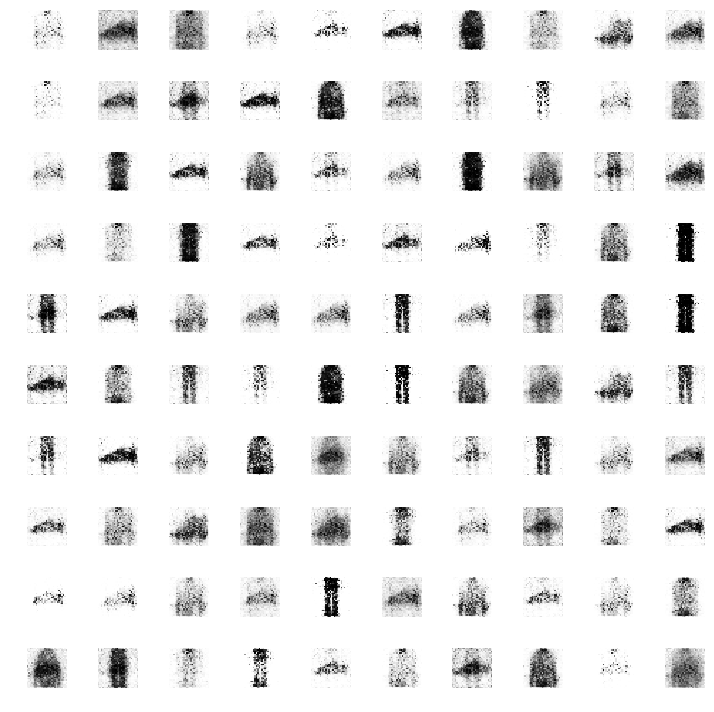

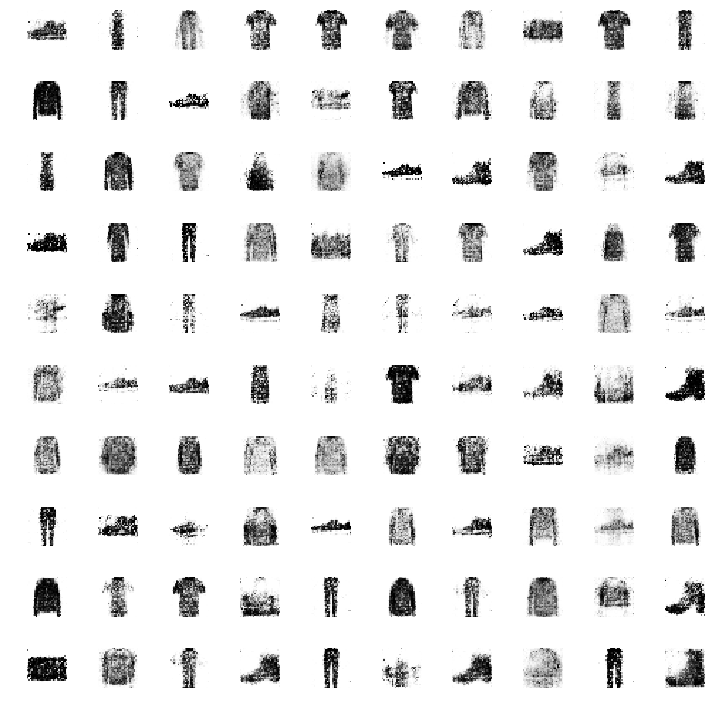

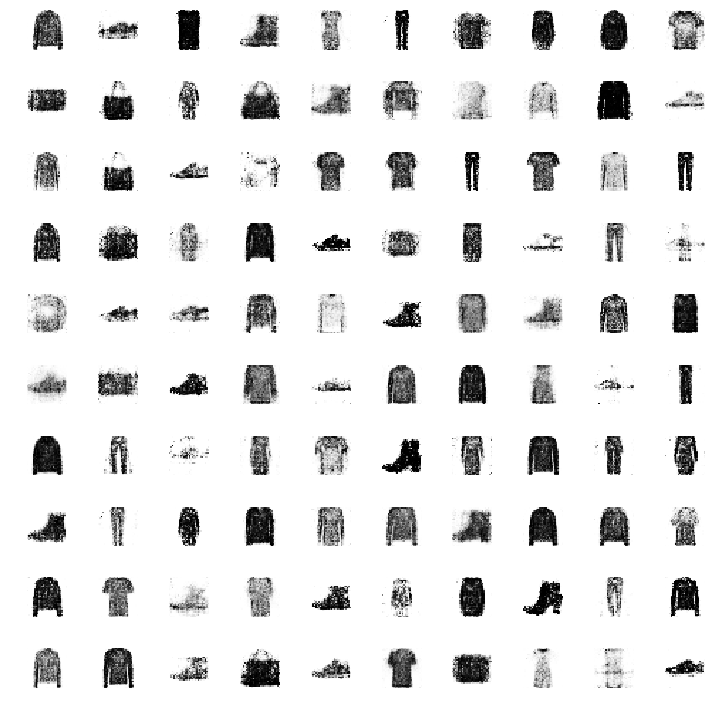

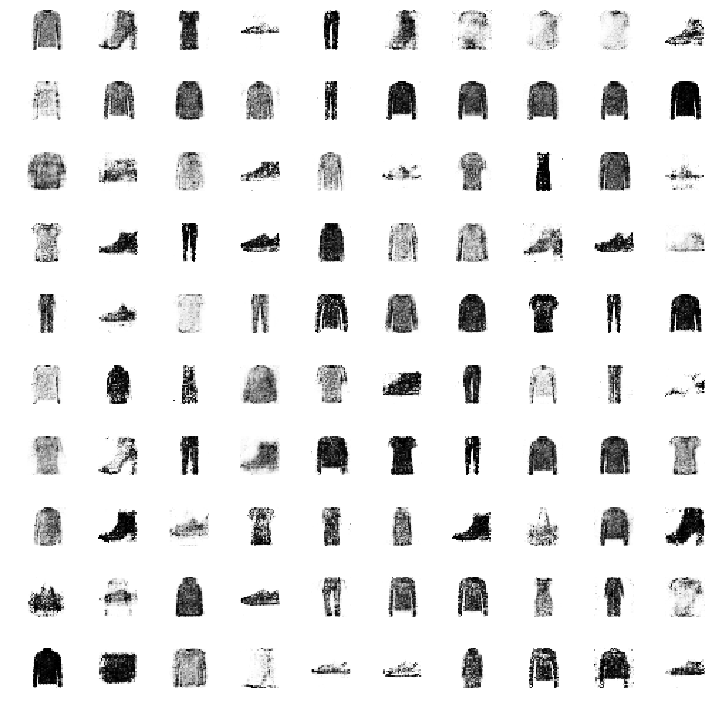

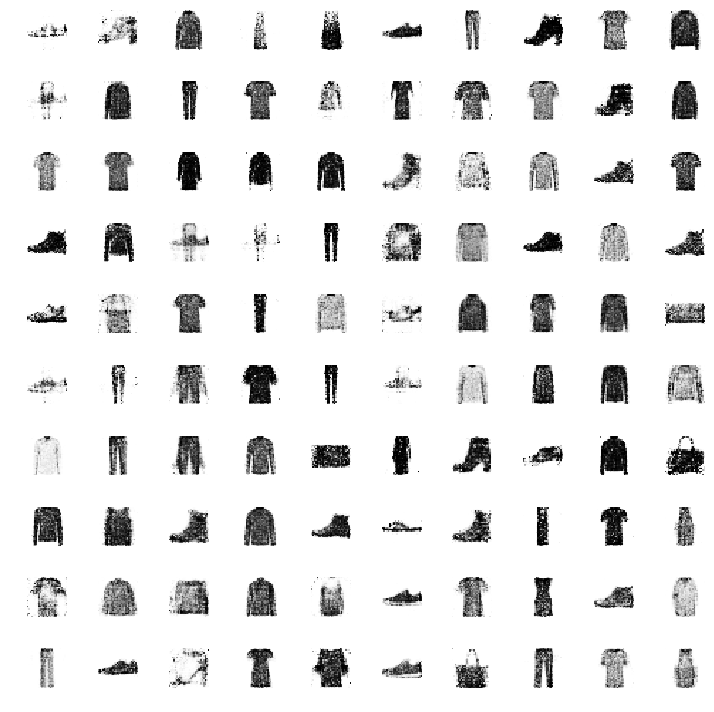

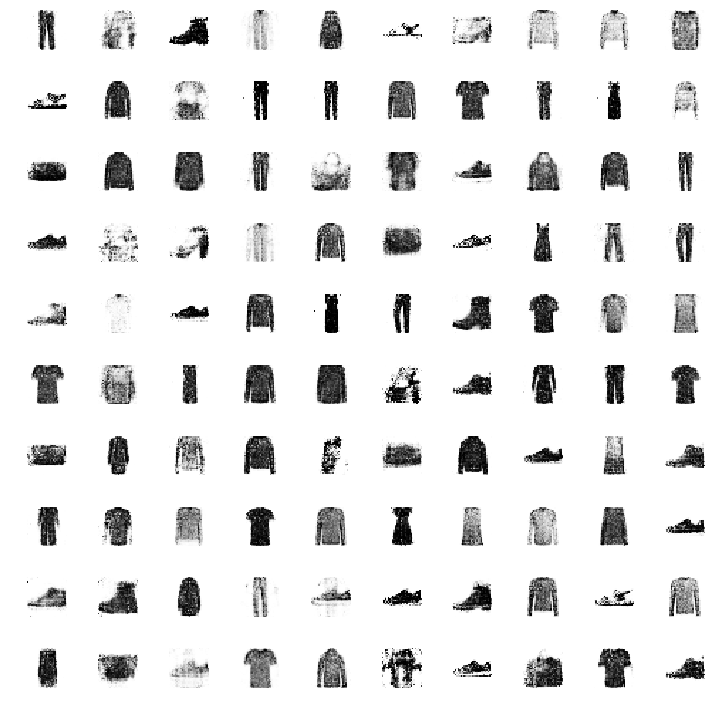

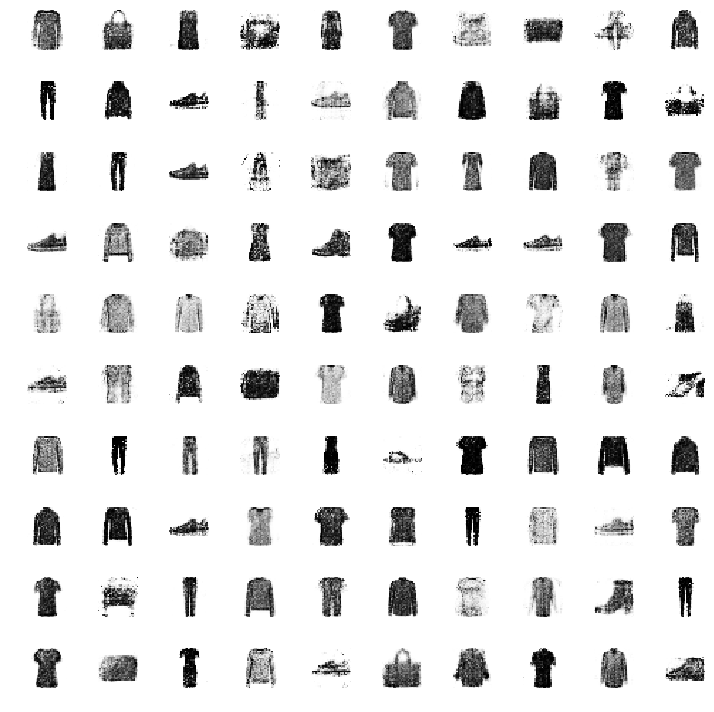

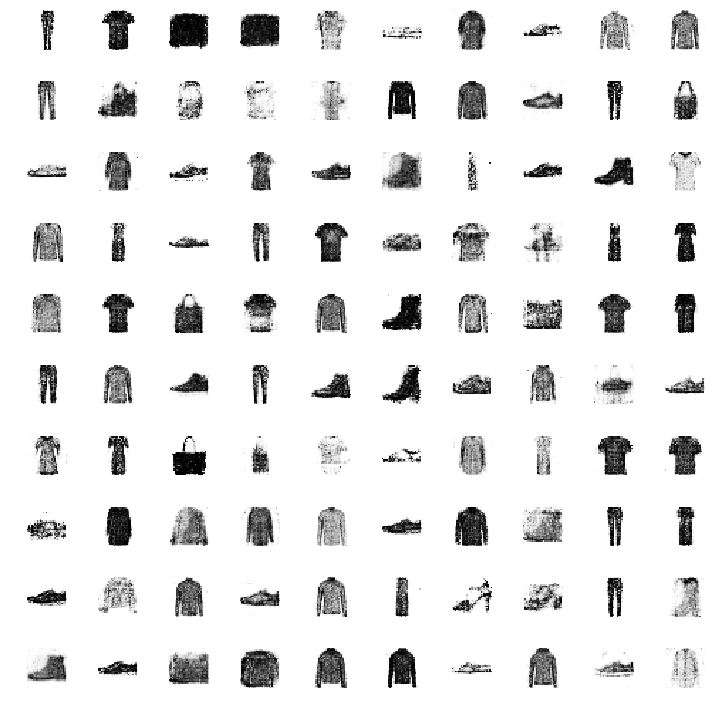

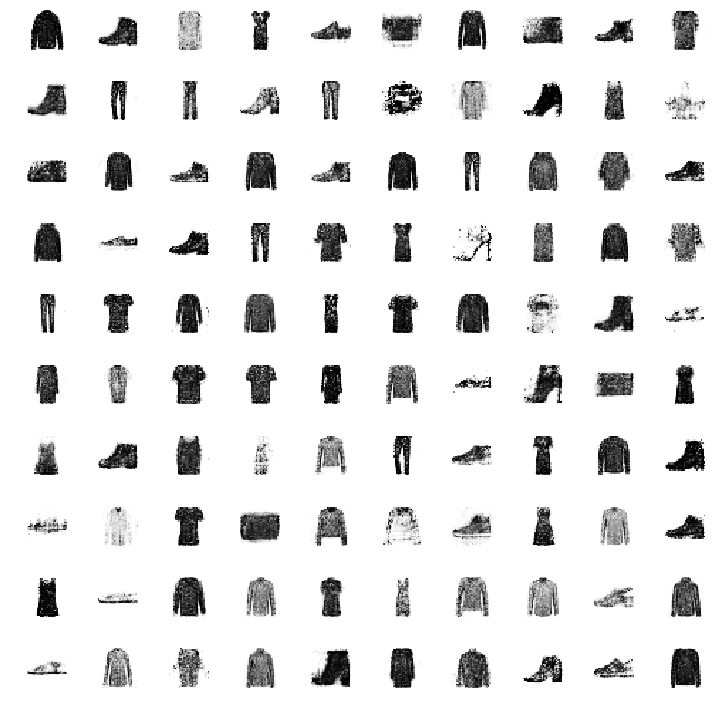

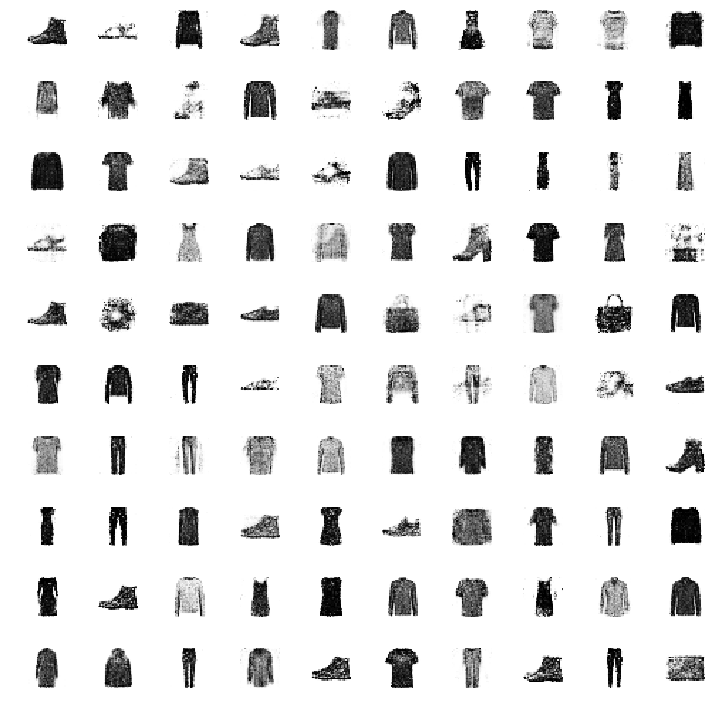

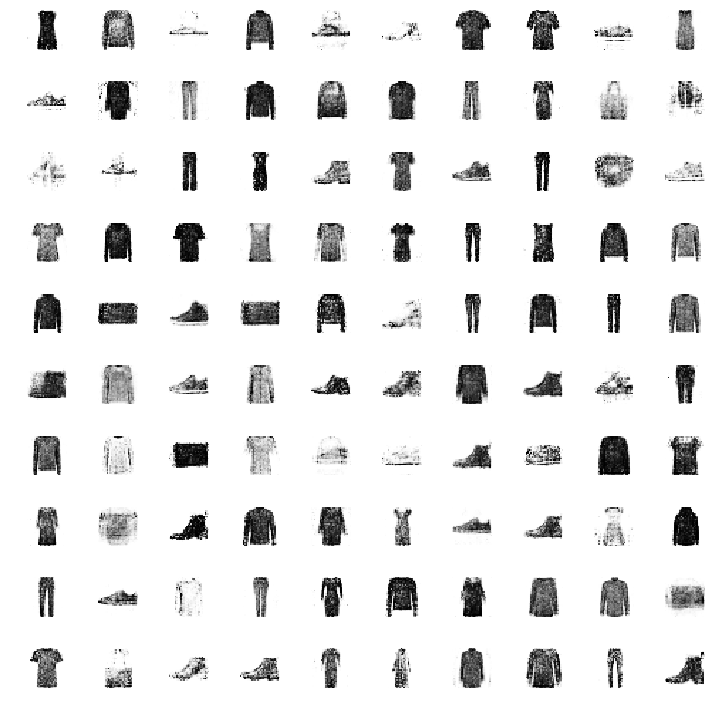

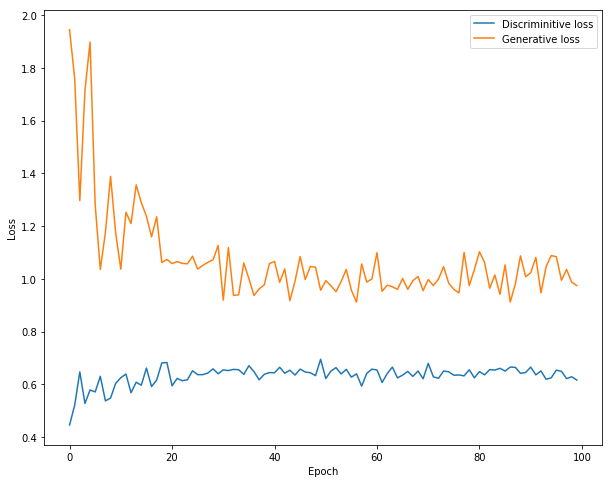

In [0]:
train(100, 128)